# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [277]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()
hosts = list(hosts)
#hosts = hosts.append('hi')

print(hosts)

['1309', '3021', '3370', '3982', '4038', '4258', '4536', '4639', '5584']


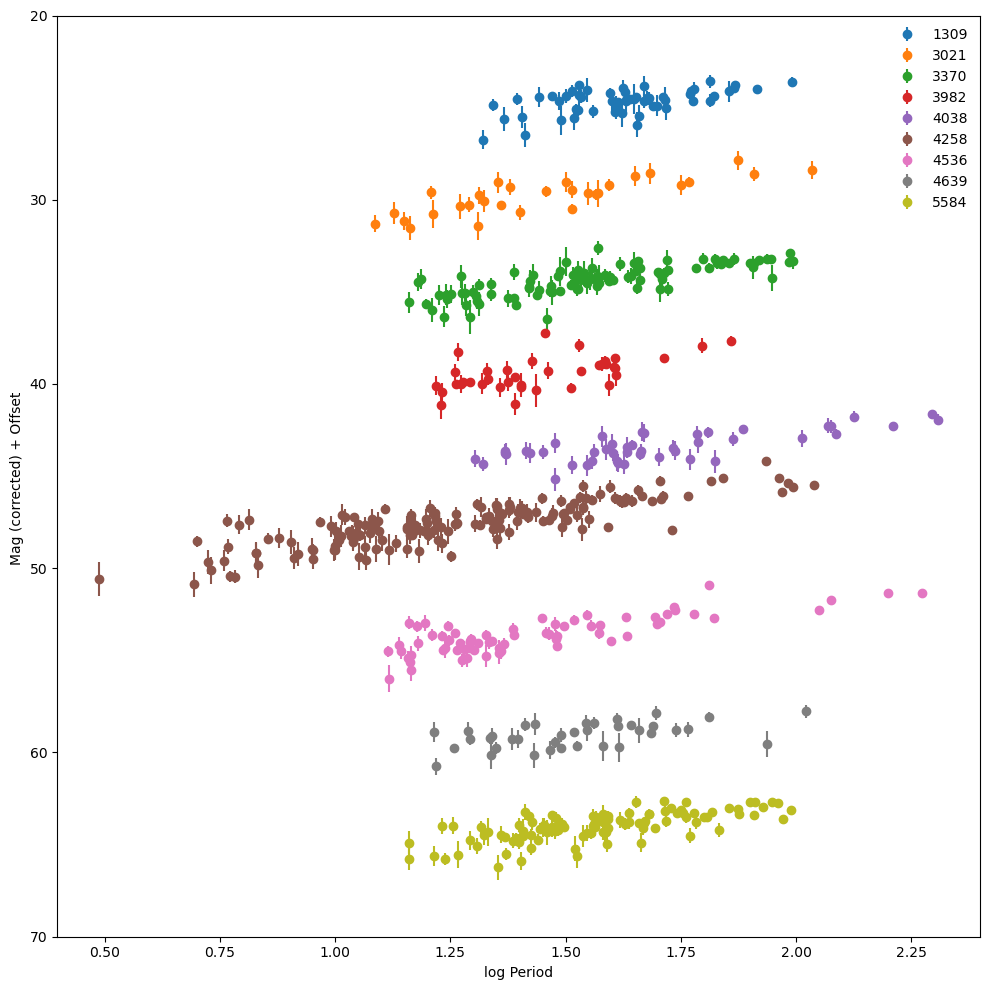

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_ylim(70,20)
#ax.set_xlim(2.5,0.25)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


$$model_{W,i,j} \equiv (\mu_{0,i} − \mu_{0,4258}) + zp_{W,4258} + b_W\log(P_{i,j})$$

The $j$-th cepheid magnitude of $i$-th host is written as $m_{W,i,j}$. $zp$ is the fitted intercept for NGC4258. $\mu_{0,i}-\mu_{0,4258}$ is reddening free distances w/rt $\mu_{0,4258}$ (distance modulus)

Paper states that it minimized $\chi^2$ for fitting, thus the likelihood function (I assume) will follow that:

$$\chi_{i,j}^2 = \frac{(m_{obs,i,j} - model(a_{i,j},b_{i,j}, logP_{i,j}))^2}{\sigma_{err,i,j}^2+\sigma_{int,i,j}^2}$$

where $a_{i,j}, b_{i,j}$ are the fitted values for $b_W$ and $(\mu_{0,i} − \mu_{0,4258})$ respectively. We thus have a double sum, where we need to sum over all j, and then sum over all i.

$$\chi_{tot}^2 = \sum_i\sum_j\frac{(m_{obs,i,j} - model(a_{i,j},b_{i,j}, logP_{i,j}))^2}{\sigma_{err,i,j}^2+\sigma_{int,i,j}^2}$$

The -lnL that we need to minimize is $0.5\chi^2$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

Each galaxy has its own set of parameters (specifically distance modulus). So what parameters need priors? Slope and intercept.
Each cepheid will have a different intercept/distance modulus but the same slope slope. It should also be noted that the distance moduli are dependent on that of NGC4258, because u_i-u_4258 for i=4258 will be 0, leaving only zp.
This zp is an intrinsic intercept for all cepheid magnitudes, and as such all other intercepts are correlated to it. 

The priors for each intercept will be normal distributions around an estimate of their distance modulus, calculated via

$$ 5*\log_{10}(z_i/z_{4258})$$

Which we already have the required redshift values.

For the slope, we can assume just by looking at the plot provided above that it will be negative. Estimating the general slope (y2-y1)/(x2-x1) for any of the cepheids above will yield about -3. So we can say our prior for the slope should be uniform over an interval of (-10, 0)


# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as so

#need to find starting guess for the intercept for NGC4258
ceph.select('4258')
def modelz(a,b,logP):
        mag = a*logP + b
        return mag
    
#function for log likelihood
def log_likelihood(theta, *args):
    a,b = theta
    logP,mobs,err = args
    mod = modelz(a,b,logP)
    lnL = ((mobs - mod)**2.)/(2*err**2.)
    return np.sum(lnL)

def nlnL(theta,*args):
    return -log_likelihood(theta,*args)


bounds = [(-5,0),(20,35)]
guess = [-3.33, 26.25]
args = (ceph.logP, ceph.mobs, ceph.sigma)

res = so.minimize(log_likelihood, guess, args=args, bounds=bounds)
print(res.x)

[-2.94832754 26.26490193]


In [308]:
import emcee
import corner
import scipy.stats as st
import astropy.units as u
import astropy.constants as const

def simulMCMC(file):
    ceph = Cepheids(file)
    #zp = fitted value for NGC4258 intercept 
    zp = res.x[1]
    
    def mguess(redshift):
        z4258 = ceph.redshifts['4258']
        return 5*np.log10(redshift/z4258)
        
    def modmodel(a,b,*args):
        zp,logP = args
        model = a*logP + b + zp
        return model
    
    #use ceph built in negloglikelihood function
    def lnpriors(theta):
        pr = np.zeros(len(theta))
        for i,ID in enumerate(hosts):
            if ID == '4258':
                pr[i] = 0
            else:
                ceph.select(ID)
                pr[0] = st.norm.pdf(theta[i],loc = mguess(ceph.redshifts[ID]), scale = 3*np.std(ceph.mobs))
        if theta[-1]<= -10 or theta[-1]>=0:
            pr[-1] = -np.inf
        else:
            pr[-1] = 0
        return np.sum(pr)
    
    def log_posterior(theta):
        chi2=np.zeros(len(theta))
        for i, ID in enumerate(hosts):
            ceph.select(ID)
            args= [theta[-1],theta[i]+zp]
            chi2[i] = (-ceph.negative_log_likelihood(args))
        nlnL = np.sum(chi2)
        lnprior = lnpriors(theta)
        post = lnprior + nlnL
        return post
    
    def distance_modulus(z,H0):
        H0 = H0*u.km/(u.s*u.Mpc)
        d = z*const.c/H0
        return 5*np.log10(d)-5

    
    def guessgen(nwalkers,ndim):
        
        guess=np.zeros((nwalkers,ndim))
        for i,ID in enumerate(hosts):
            if ID =='4258':
                guess[:,i]=st.norm.rvs(loc=0,scale=1,size= nwalkers)
            else:
                ceph.select(ID)
                guess[:,i] = st.norm.rvs(loc = mguess(ceph.redshifts[ID]),\
                                         scale = 4*np.std(ceph.mobs), size = nwalkers)
        guess[:,-1]= np.random.uniform(-10,-0.1,size = nwalkers)
        return guess
    
    nburn = 2000
    nsteps = 5000
    nwalkers = 20
    ndim = 10 #ndim = 9 intercepts for each cepheid plus 1 slope
    
    starting_guesses = guessgen(nwalkers,ndim) 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
    state = sampler.run_mcmc(starting_guesses, nburn) 
    sampler.reset()                    
    sampler.run_mcmc(state, nsteps, progress=True);
    samples = sampler.get_chain(flat=True)
    
    
    
    #median fit values for samples
    mcmc_res = np.percentile(samples[::], 50, axis=0)
    
    #we know that the intercept for NGC4258 should be zero, so if it's fit isn't 0, we add that offset to our zp
    #we then have to remove that offset from our fitted intercept points
    # the intercept for NGC4258 is stored in the 5th index
    zp_true = zp + mcmc_res[5]
    for i in range(9):
        mcmc_res[i] = mcmc_res[i] - mcmc_res[5]


    plt.figure(figsize=(12,8))
    for i,ID in enumerate(hosts):
        plt.subplot(331+i)
        ceph.select(ID)
        logP = ceph.logP
        merr = ceph.sigma
        mobs = ceph.mobs
        plt.errorbar(logP, mobs, yerr=merr, linestyle='None',marker='o',\
                     label=ID,color='#67032F')
        lParr = np.linspace(logP.min()-0.01,logP.max()+0.1,1000)
        plt.plot(lParr,modmodel(mcmc_res[-1],mcmc_res[i],zp_true,lParr),c='k')
        plt.ylabel('F160W (mag)')
        plt.xlabel('log Period (days)')
        plt.title(f'NGC{ID}: # of cepheids = {len(mobs)}')
        #invert y-axes
        plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # plot of all of the chains
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
    plt.suptitle('Traceplots')
    labels=['1309', '3021', '3370', '3982', '4038', '4258', '4536', '4639', '5584','bW']
    for i in range(samples.shape[1]):
        j, k = np.unravel_index(i, (4,3))
        ax = axs[j][k]
        ax.plot(samples[::10,i], linestyle='-', color='grey', marker='.', alpha=0.1)
        med = np.median(samples[:,i])
        std = np.std(samples[:,i])
        ax.set_ylim(med-3*std, med+3*std) 
        ax.set_ylabel(labels[i])
        
            
    cplot = corner.corner(samples[::], plot_contours=True, show_titles=True, smooth=2);
    
    return [samples,mcmc_res]

100%|██████████████████████████████████████| 5000/5000 [03:27<00:00, 24.14it/s]


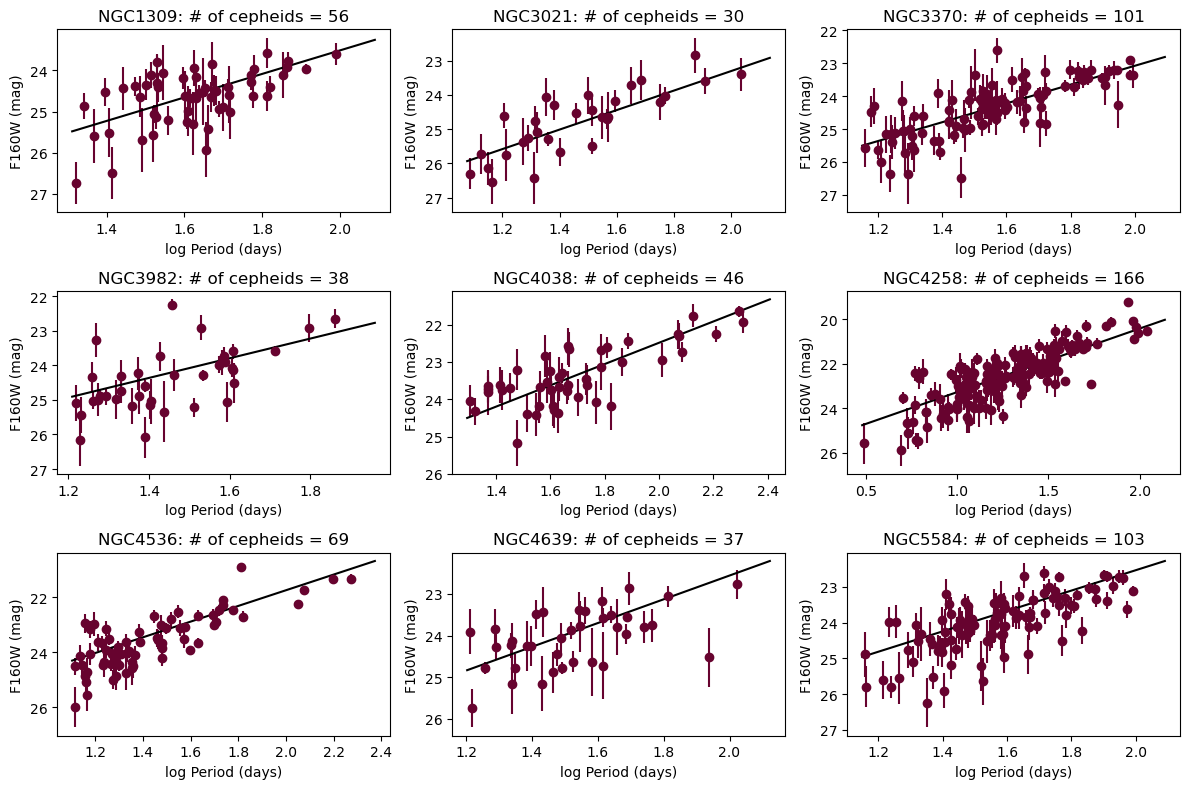

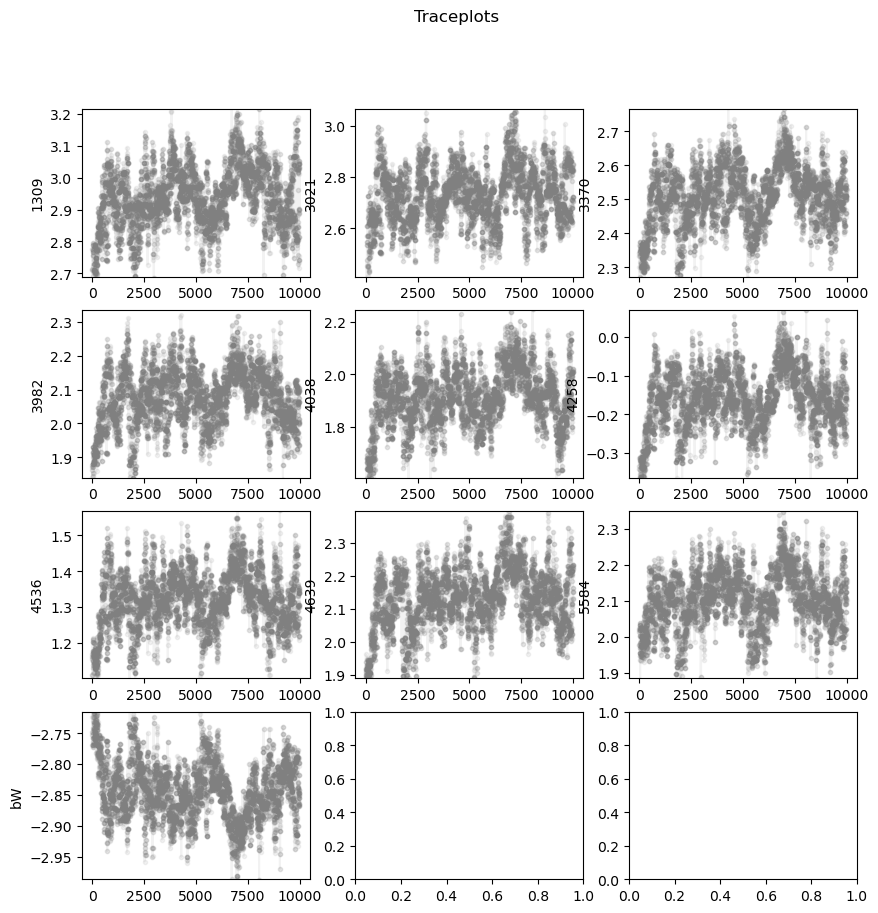

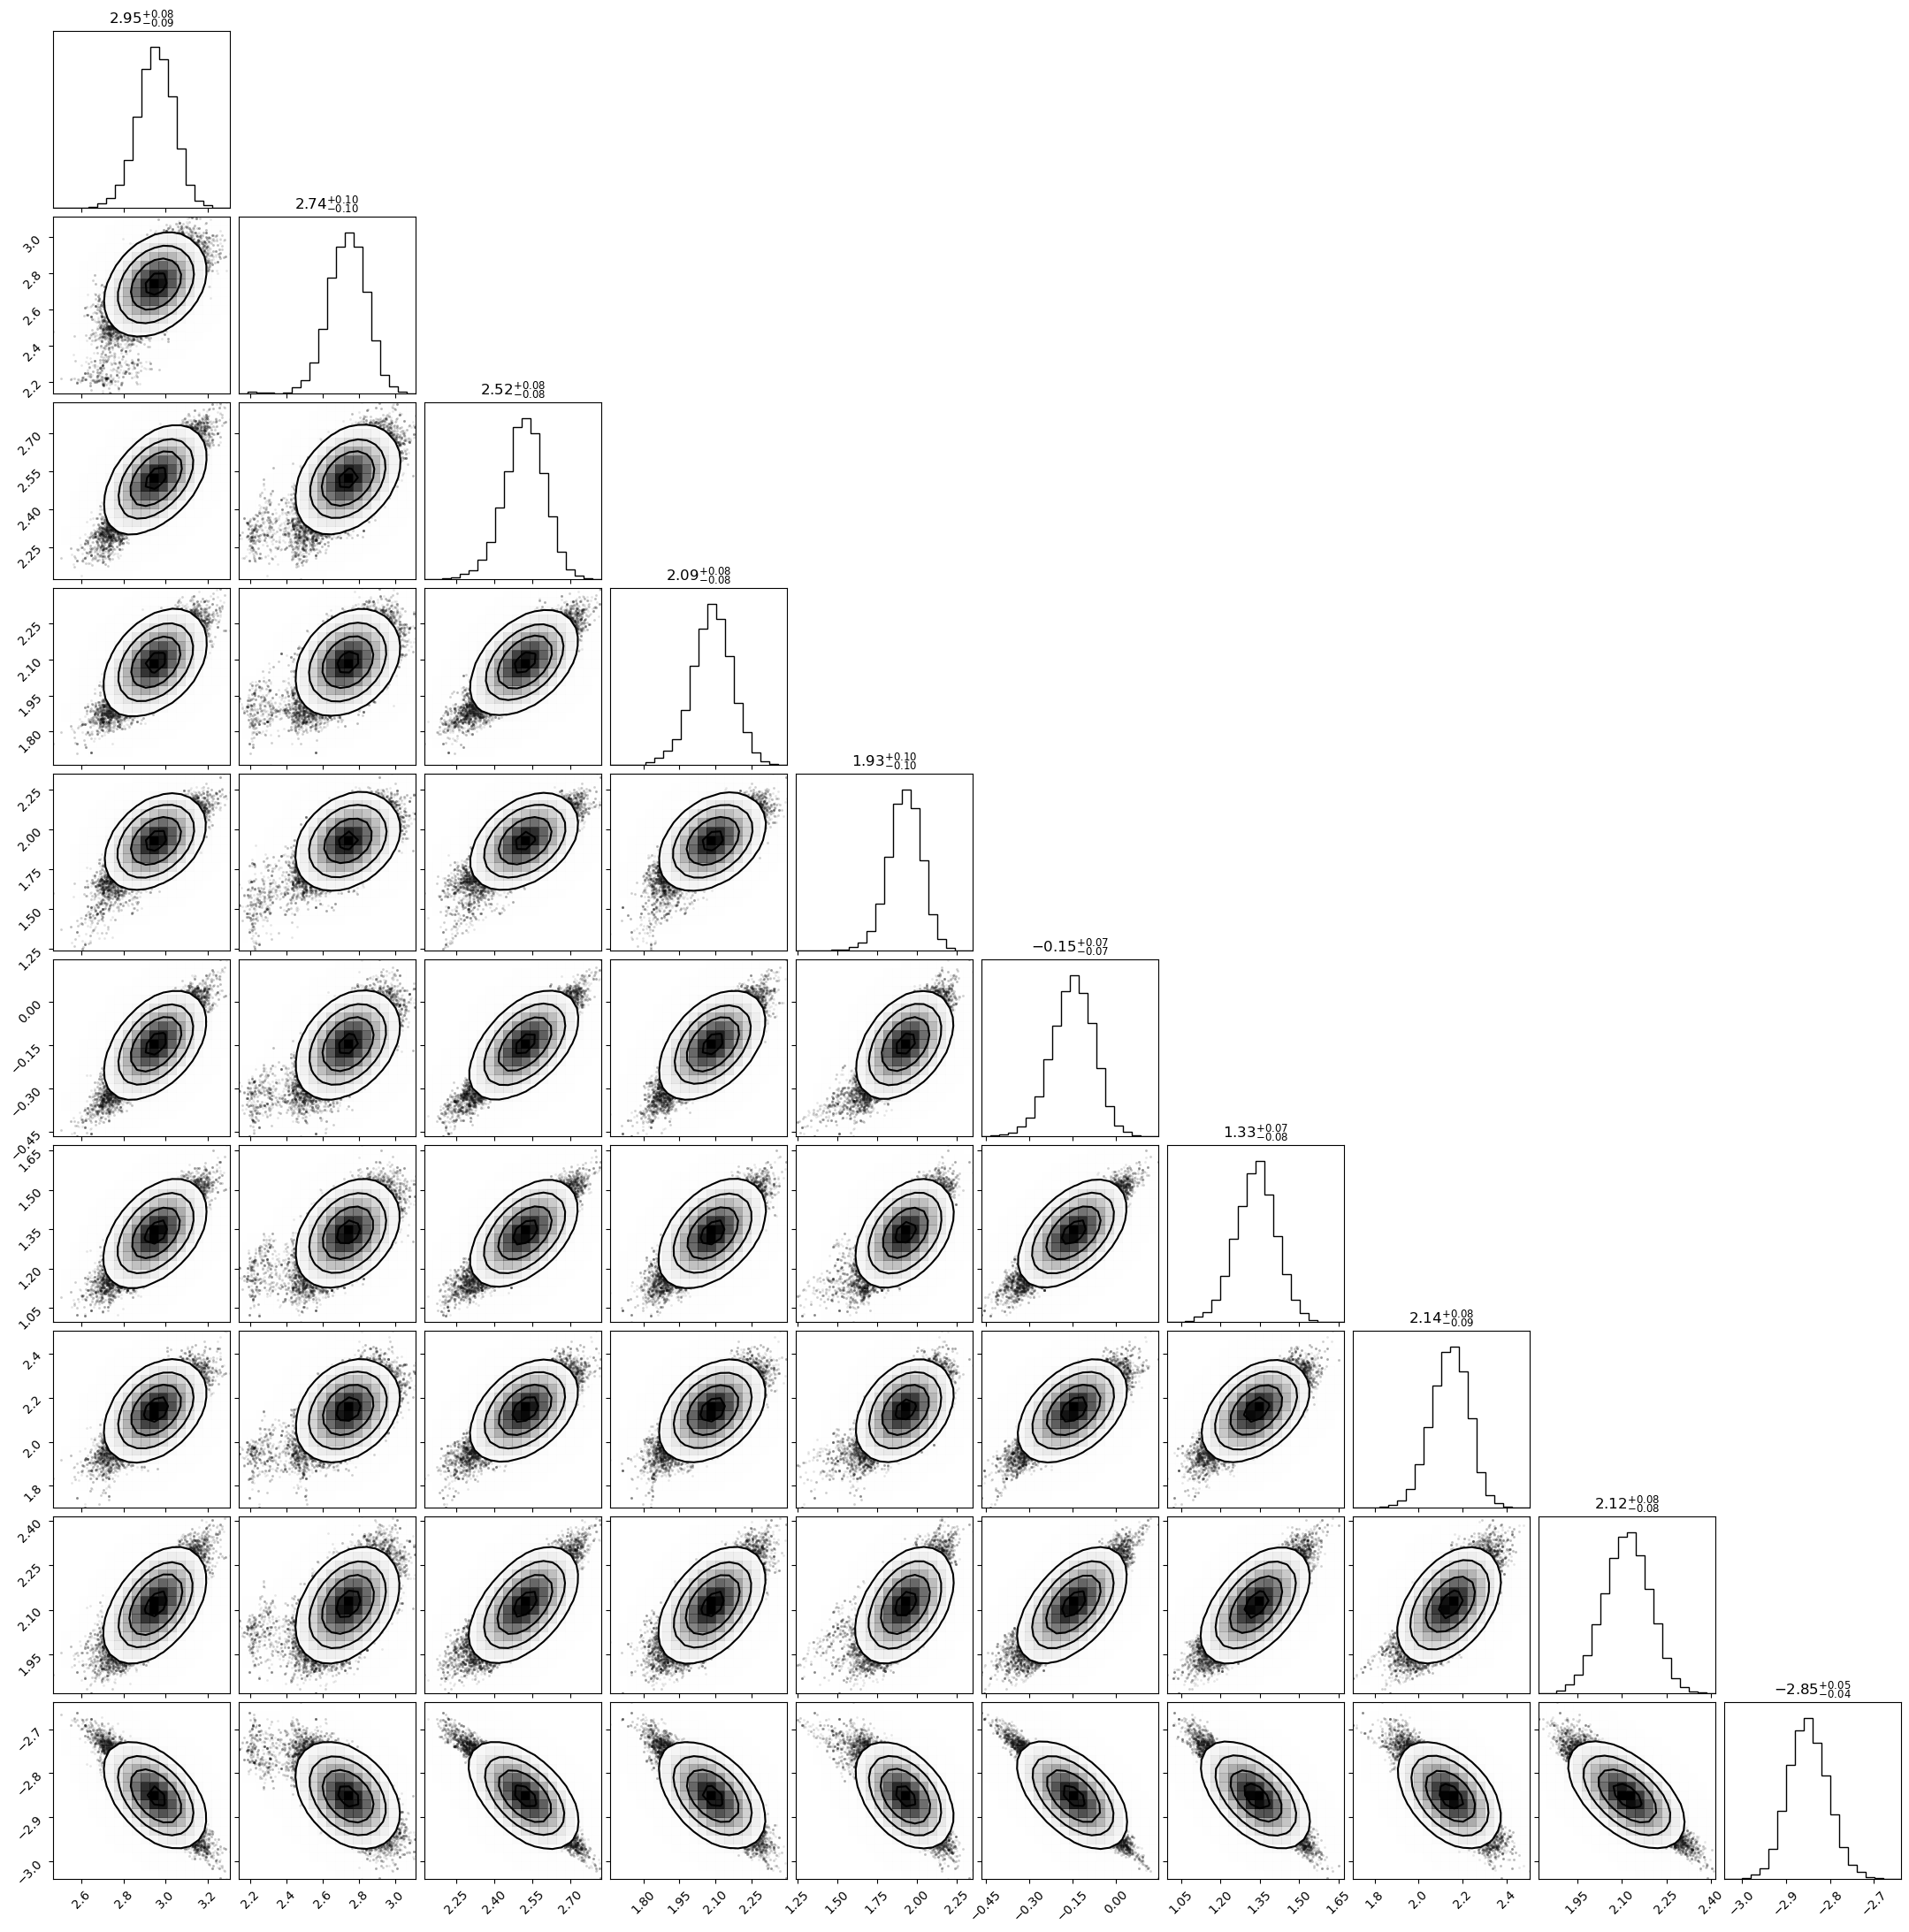

In [309]:
mdat = simulMCMC('R11ceph.dat')



# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

From Equation 3

$$m^0_{v,i} = (\mu_{0,i} − \mu_{0,4258}) + m^0_{v,4258}$$

Which can be rewritten to solve for $m^0_{v,4258}$

$$m^0_{v,4258} = m^0_{v,i} - (\mu_{0,i} − \mu_{0,4258})$$

Thus, if we substitute that into Equation 4 we get

$$ \log(H_0) = \frac{m^0_{v,4258}− \mu_{0,4258} +5a_v +25}{5}$$

$$ \log(H_0) = \frac{m^0_{v,i} - (\mu_{0,i} − \mu_{0,4258})− \mu_{0,4258} +5a_v +25}{5}$$

$$ = \frac{m^0_{v,i}+5a_v -(\mu_{0,i} − \mu_{0,4258}) - \mu_{0,4258} + 25}{5}$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [311]:
#from paper, the value for the distance to NGC4258 is 
d4258 = 7.60e5

#the equation derived in Q4 requires mu_0,4258, which is not provided in Table 3 so

mu4258 = 5*np.log10(d4258)

#Table 3 supplies us with values for m_v,i + 5a_v, which we store in 

T3 = np.array([16.768, 16.699, 16.545, 15.953, 15.901,\
                        0,\
                        15.147, 16.040, 16.274])
# this contains a fake data point for NGC4258 so that the array length is same as hosts
logH0 = np.zeros(9)
for i,ID in enumerate(hosts):
    mv_5a = T3[i]
    mu_int = mdat[1][i] 
    logH0[i] = (mv_5a - mu_int - mu4258 + 25)/5
    count+=1

Hmask = logH0>0.
logH0 = logH0[Hmask]
lHerr = np.std(logH0)
H0 = np.mean(10**logH0)
Herr = 10**lHerr

print(r'The average value for the Hubble constant is {} +/- {} km / s Mpc'.format(H0,Herr))

The average value for the Hubble constant is 77.53093495678482 +/- 1.0651632419000625 km / s Mpc
